In [ ]:
pip install linearmodels

     |████████████████████████████████| 1.5MB 7.1MB/s 


In [ ]:
latex = False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import statsmodels.api as sm
from linearmodels import IV2SLS
from collections import OrderedDict
from linearmodels.iv.results import compare
from statsmodels.iolib.summary2 import summary_col
from sklearn.model_selection import train_test_split
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#data1 = '/content/drive/MyDrive/Colab Notebooks/Cause & Effect HW/HW_final/census-income.data'
#data2 = '/content/drive/MyDrive/Colab Notebooks/Cause & Effect HW/HW_final/census-income.test'
data = '/content/drive/MyDrive/Colab Notebooks/Cause & Effect HW/HW_final/cps.csv' #Sam

try:
  data = '/content/drive/MyDrive/Colab Notebooks/Cause & Effect HW/HW_final/cps.csv'
  df_income_original = pd.read_csv(data, sep=',')
except:
  data = '/content/drive/MyDrive/cps.csv'
  df_income_original = pd.read_csv(data, sep=',')

#df_income1 = pd.read_csv(data1, sep=',', header=None)
#df_income2 = pd.read_csv(data2, sep=',', header=None)

#df_income = pd.concat([df_income1, df_income2])
#df_income = df_income.rename(columns = {0 : "age", 1: "class_of_worker", 2: "detailed_industry_recode", 3: "detailed_occupation_recode", 4: "education", 5: "wage_per_hour", 6:"enroll_in_edu_inst_last_wk", 7:"marital_stat", 8:"major_industry_code", 9:"major_occupation_code", 10:"race", 11:"hispanic_origin", 12:"sex", 13:"member_of_labour_union", 14:"not_sure1", 15:"reason_for_unemployment", 16:"capital_gains", 17:"capital_losses", 18:"dividends_from_stocks", 19:"tax_filer_stat", 20:"region of previous residence", 21:"state_of_previous_residence", 22:"detailed_household_and_family_stat", 23:"detailed_household_summary_in_household", 24:"instance_weight", 25:"migration_code-change_in_msa", 26:"migration_code-change_in_reg",27:"migration_code-move_within_reg",28:"live_in_this_house_1_year_ago",29:"migration_prev_res_in_sunbelt", 30:"num_persons_worked_for_employer", 31:"family_members_under_18", 32:"country_of_birth_father", 33:"country_of_birth_mother", 34:"country_of_birth_self", 35:"citizenship", 36:"own_business_or_self_employed", 37:"fill_inc_questionare_for_veteran's_admin",38:"veterans_benefits", 39:"weeks_worked_in_year", 40:"year", 41:"income_projected"})
df_income_original = df_income_original.sample(frac=1, random_state = 42) #shuffles the data

In [ ]:
#-------------CLEAN UP DATA
df_income = df_income_original.copy()
#CLEAN UP MARRIAGE STATUS
df_income = df_income.drop(df_income[df_income['MARST'] == 9].index)
df_income = df_income[df_income['MARST'].notna()]
#CLEAN UP SEX STATUS
df_income = df_income.drop(df_income[df_income['SEX'] == 9].index)
df_income = df_income[df_income['SEX'].notna()]
df_income["SEX"] = df_income["SEX"].replace({1:1, 2:0}) #1 is male, 0 is female
#CLEAN UP INCWAGE STATUS
df_income = df_income.drop(df_income[df_income['INCWAGE'] == 99999999].index)
df_income = df_income.drop(df_income[df_income['INCWAGE'] == 99999998].index)
df_income = df_income[df_income['INCWAGE'].notna()]
#CLEAN UP STATE CODING
df_income = df_income.drop(df_income[df_income['STATEFIP'] >=57].index)
#CLEAN UP PUB HOUSE
df_income = df_income.drop(df_income[df_income['PUBHOUS'] == 0].index)
df_income["PUBHOUS"] = [0 if x == 1 
                        else 1 for x in df_income["PUBHOUS"]]
#CLEAN UP RACE
df_income = df_income.drop(df_income[df_income['RACE'] == 999].index)
df_income["RACE"] = [1 if x == 100 
                     else 0 for x in df_income["RACE"]] #1 IF PERSON IS WHITE, 0 OTHERWISE
#CLEAN UP MOTHER'S BIRTHPLACE DATA
df_income = df_income.drop(df_income[df_income['MBPL'] == 99999].index)
df_income["MBPL"] = [1 if x == 9900 
                     else 0 for x in df_income["MBPL"]]
#CLEAN UP FATHER'S BIRTHPLACE DATA
df_income = df_income.drop(df_income[df_income['FBPL'] == 99999].index)
df_income["FBPL"] = [1 if x == 9900 
                     else 0 for x in df_income["FBPL"]]
#CLEAN UP LABOR FORCE 
df_income = df_income.drop(df_income[df_income['EMPSTAT'] == 00].index)
df_income["NILF"] = [1 if x > 29 
                     else 0 for x in df_income["EMPSTAT"]] #1 is not in labor force, 0 is in labor force

df_income = df_income.drop(df_income[df_income['NILF'] == 1].index) #Based off suggestion from Loujaina to only analyze people in Labor Force

df_income["Employment"] = [1 if x == 1 or x == 10 or x == 12
                     else 0 for x in df_income["EMPSTAT"]] # 1 is employed, 0 is not employed (doesn't mean unemployed)
#CLEAN UP CLASS OF WORKER
#df_income = df_income.drop(df_income[df_income['CLASSWKR'] == 99].index)
#CLEAN UP EDUCATION OF WORKER (EDUC99)
df_income = df_income.drop(df_income[df_income['EDUC99'] == 00].index)
df_income["High School"] = [1 if x > 9 and x < 15
                     else 0 for x in df_income["EDUC99"]]
df_income["College"] = [1 if x > 14
                     else 0 for x in df_income["EDUC99"]]
#DROP 2020 CENSUS DATA
df_income = df_income.drop(df_income[df_income['YEAR'] == 2020].index)
#ADDING MARRIAGE STATUS DUMMY

df_income.loc[df_income['MARST'] == 1, 'marriage_status'] = 1
df_income.loc[df_income['MARST'] == 2, 'marriage_status'] = 1
df_income.loc[df_income['MARST'] == 3, 'marriage_status'] = 1
df_income.loc[df_income['MARST'] == 4, 'marriage_status'] = 0
df_income.loc[df_income['MARST'] == 5, 'marriage_status'] = 0
df_income.loc[df_income['MARST'] == 6, 'marriage_status'] = 0
df_income.loc[df_income['MARST'] == 7, 'marriage_status'] = 0

df_income


,YEAR,SERIAL,MONTH,HWTFINL,CPSID,ASECFLAG,HFLAG,ASECWTH,STATEFIP,STATECENSUS,HHINCOME,PUBHOUS,FAMINC,QFAMINC,QPUBHOUS,HRHHID,HRHHID2,PERNUM,WTFINL,CPSIDP,ASECWT,AGE,SEX,RACE,MARST,QAGE,QMARST,QSEX,QRACE,NCHILD,YNGCH,FTYPE,FAMREL,MBPL,FBPL,QFBPL,QMBPL,EMPSTAT,OCC,IND,CLASSWKR,QCLASSWK,QEMPSTAT,QIND,QOCC,EDUC,EDUC99,QEDUC,FAMID,OCCLY,CLASSWLY,WKSWORK1,WKSWORK2,QCLASSWL,QOCCLY,QWKSWORK,FTOTVAL,INCTOT,INCWAGE,INCCAPG,QINCCAPG,ADJGINC,CAPGAIN,CAPLOSS,MIGSTA1,MIGSTA5,QMIGST1B,CSYRDIV,HOURWAGE,QHOURWAG,TAVG1,VOTERES,NILF,Employment,High School,College,marriage_status
14496,2008,7284,3,NaN,20080105691700,1.0,NaN,506.26,44,15,11702.0,1,600,NaN,0.0,544074032904372,84001,2,NaN,20080105691702,578.57,23,1,1,6,0,0,0,NaN,0,99,1,3,1,1,0,0,10,9620,2880,21,0.0,0.0,0,0,50,7,0,1.0,9620.0,22.0,15.0,2.0,0.0,0.0,0.0,11702.0,2300.0,2300.0,NaN,NaN,2300.0,0.0,0.0,99.0,NaN,0.0,9999.0,999.99,0,NaN,NaN,0,1,0,0,0.0
423498,2010,4804,3,NaN,20100104169400,1.0,NaN,292.58,50,13,25223.0,1,740,NaN,0.0,591972901092079,87001,1,NaN,20100104169401,292.58,53,0,1,2,0,0,0,0.0,0,99,2,0,1,1,0,0,10,2310,7860,28,0.0,0.0,0,0,123,16,0,1.0,2310.0,28.0,41.0,4.0,0.0,0.0,0.0,25223.0,25223.0,8000.0,NaN,NaN,8223.0,NaN,NaN,99.0,NaN,0.0,9999.0,999.99,0,NaN,NaN,0,1,0,1,1.0
1019107,2012,91357,3,NaN,20101206287600,1.0,NaN,2138.50,6,93,71420.0,0,830,NaN,0.0,870465090105899,88001,1,NaN,20101206287601,2138.50,48,1,0,4,0,0,0,0.0,0,99,2,0,1,1,0,0,10,3730,5070,21,0.0,0.0,0,0,91,13,0,1.0,3730.0,22.0,52.0,6.0,0.0,0.0,0.0,54620.0,54620.0,45000.0,NaN,NaN,45020.0,NaN,NaN,99.0,NaN,0.0,NaN,8.25,4,NaN,NaN,0,1,1,0,0.0
1463965,2015,16829,3,NaN,20140105472500,1.0,NaN,2003.29,42,23,114000.0,0,740,NaN,0.0,933052394429930,93001,1,NaN,20140105472501,2003.29,31,0,0,2,0,0,0,NaN,2,4,1,1,1,1,0,0,10,230,8470,13,0.0,0.0,0,0,111,15,0,1.0,230.0,13.0,52.0,6.0,0.0,0.0,0.0,114000.0,114000.0,0.0,NaN,NaN,105946.0,NaN,NaN,99.0,42.0,0.0,NaN,999.99,0,NaN,NaN,0,1,0,1,1.0
274887,2009,32029,3,NaN,0,1.0,NaN,852.90,27,41,34000.0,0,720,NaN,0.0,36622370994196,83001,1,NaN,0,852.90,26,0,0,6,0,0,0,NaN,0,99,2,0,1,1,0,0,10,120,6870,21,0.0,0.0,0,0,111,15,0,1.0,120.0,22.0,52.0,6.0,0.0,0.0,0.0,34000.0,34000.0,32000.0,NaN,NaN,34000.0,NaN,NaN,99.0,NaN,0.0,NaN,999.99,0,NaN,NaN,0,1,0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1870230,2017,28004,3,NaN,20161203665100,1.0,NaN,2834.47,29,43,55275.0,0,500,NaN,0.0,927050986501102,6011,1,NaN,20161203665101,2834.47,24,0,0,6,0,0,0,NaN,0,99,2,0,1,0,0,0,10,3420,5070,21,0.0,0.0,0,0,91,13,0,1.0,3420.0,22.0,52.0,6.0,0.0,0.0,0.0,55275.0,55275.0,45000.0,NaN,NaN,52578.0,NaN,NaN,99.0,NaN,0.0,NaN,15.25,0,NaN,NaN,0,1,1,0,0.0
1311736,2014,39845,3,NaN,0,1.0,0.0,1813.08,12,59,43100.0,0,710,NaN,0.0,215209997277962,91001,1,NaN,0,1813.08,36,0,1,4,0,0,0,NaN,1,12,1,1,1,0,0,0,10,4230,7690,21,0.0,0.0,0,0,73,10,0,1.0,4230.0,22.0,52.0,6.0,0.0,0.0,0.0,22000.0,22000.0,22000.0,NaN,NaN,22000.0,NaN,NaN,99.0,NaN,0.0,NaN,999.99,0,NaN,NaN,0,1,1,0,0.0
564685,2010,71441,3,NaN,20090306059900,1.0,NaN,1451.85,48,74,29700.0,0,470,NaN,1.0,138569780839402,85001,1,NaN,20090306059901,1451.85,33,0,1,3,0,0,0,0.0,2,7,1,1,0,0,0,0,21,2630,5470,21,0.0,0.0,0,0,10,4,0,1.0,2630.0,22.0,52.0,6.0,0.0,0.0,0.0,29700.0,24000.0,24000.0,NaN,NaN,24000.0,NaN,NaN,99.0,NaN,0.0,2007.0,999.99,0,NaN,NaN,0,0,0,0,1.0
528178,2010,53894,3,NaN,20091206772500,1.0,NaN,1547.05,13,58,15000.0,1,710,NaN,0.0,501907231894663,87001,1,NaN,20091206772501,1547.05,30,0,0,6,0,0,0,0.0,1,7,1,1,1,1,0,0,10,4520,8980,21,0.0,0.0,0,0,73,10,0,1.0,4520.0,22.0,52.0,6.0,0.0,0.0,0.0,15000.0,15000.0,15000.0,NaN,NaN,15000.0,NaN,NaN,99.0,NaN,0.0,9998.0,10.00,0,NaN,NaN,0,1,1,0,0.0


In [ ]:
#SPLIT DATA SET FOR CALCULATING STATE MARRIED RATE
df_income_main , df_income_remain = train_test_split(df_income, test_size=0.6, random_state=100, shuffle=True)

In [ ]:
df_income["WKSWORK2"].value_counts()

6.0    261427
0.0     23765
2.0     19774
4.0     18721
3.0     16515
1.0     11855
5.0      6591
Name: WKSWORK2, dtype: int64

In [ ]:
#MAKING A DICTIONARY FOR STATE AVERAGE MARRIAGE RATE
from collections import defaultdict
df_income_remain[df_income_remain['STATEFIP'] == 49].marriage_status.mean()

test = [*range(1,57)]
test.remove(3)
test.remove(7)
test.remove(14)
test.remove(43)
test.remove(52)


marriage_rate = {}

for i in test:
  a = df_income_remain[df_income_remain['STATEFIP'] == i].marriage_status.mean()
  marriage_rate[str(i)] = a

In [ ]:
#CREATING COLUMN OF AVERAGE STATE MARRIAGE RATE
df_income_main["Marriage_Rate"] = df_income_main["STATEFIP"].astype("str").map(marriage_rate)

df_income_main.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,YEAR,SERIAL,MONTH,HWTFINL,CPSID,ASECFLAG,HFLAG,ASECWTH,STATEFIP,STATECENSUS,HHINCOME,PUBHOUS,FAMINC,QFAMINC,QPUBHOUS,HRHHID,HRHHID2,PERNUM,WTFINL,CPSIDP,ASECWT,AGE,SEX,RACE,MARST,QAGE,QMARST,QSEX,QRACE,NCHILD,YNGCH,FTYPE,FAMREL,MBPL,FBPL,QFBPL,QMBPL,EMPSTAT,OCC,IND,CLASSWKR,QCLASSWK,QEMPSTAT,QIND,QOCC,EDUC,EDUC99,QEDUC,FAMID,OCCLY,CLASSWLY,WKSWORK1,WKSWORK2,QCLASSWL,QOCCLY,QWKSWORK,FTOTVAL,INCTOT,INCWAGE,INCCAPG,QINCCAPG,ADJGINC,CAPGAIN,CAPLOSS,MIGSTA1,MIGSTA5,QMIGST1B,CSYRDIV,HOURWAGE,QHOURWAG,TAVG1,VOTERES,NILF,Employment,High School,College,marriage_status,Marriage_Rate
1395025,2014,79505,3,NaN,20131205894100,1.0,1.0,1139.54,46,45,123500.0,0,842,NaN,0.0,264381031409369,93001,1,NaN,20131205894101,1139.54,26,0,1,1,0,0,0,NaN,0,99,1,1,1,1,0,0,10,5700,180,21,0.0,0.0,0,0,92,14,0,1.0,5700.0,22.0,52.0,6.0,0.0,0.0,0.0,123500.0,26250.0,25000.0,NaN,NaN,123500.0,NaN,NaN,99.0,NaN,0.0,NaN,13.00,0,NaN,NaN,0,1,1,0,1.0,0.348837
1377567,2014,70837,3,NaN,20140201067300,1.0,1.0,3059.67,9,16,121080.0,0,842,NaN,0.0,490430023908574,93001,1,NaN,20140201067301,3059.67,42,0,1,6,0,0,0,NaN,0,99,2,0,0,0,0,0,10,60,8680,21,0.0,0.0,0,0,111,15,0,1.0,60.0,22.0,52.0,6.0,0.0,0.0,0.0,99080.0,99080.0,99000.0,NaN,NaN,99080.0,NaN,NaN,99.0,NaN,0.0,NaN,999.99,0,NaN,NaN,0,1,0,1,0.0,0.416259
1096770,2013,32955,3,NaN,20130102519100,1.0,NaN,549.18,19,42,41250.0,0,740,NaN,0.0,760199719900998,91001,2,NaN,20130102519102,549.18,35,0,1,1,0,0,0,0.0,3,4,1,2,0,1,0,0,10,5120,8660,21,0.0,0.0,0,0,81,11,0,1.0,5120.0,22.0,52.0,6.0,0.0,0.0,0.0,41250.0,20000.0,20000.0,NaN,NaN,0.0,NaN,NaN,99.0,NaN,0.0,NaN,999.99,0,NaN,NaN,0,1,1,0,1.0,0.360085
252918,2009,22174,3,NaN,0,1.0,NaN,1311.75,39,31,36570.0,0,600,NaN,0.0,71643190973896,86001,1,NaN,0,1311.75,35,0,0,1,0,0,0,NaN,4,0,1,1,0,1,0,0,12,4110,8680,21,0.0,0.0,0,0,81,11,0,1.0,4110.0,22.0,52.0,6.0,0.0,0.0,0.0,36570.0,18000.0,7500.0,NaN,NaN,21580.0,NaN,NaN,99.0,NaN,0.0,NaN,999.99,0,NaN,NaN,0,1,1,0,1.0,0.372123
195838,2008,92715,3,NaN,0,1.0,NaN,1906.64,6,93,157759.0,0,830,NaN,0.0,94961207041608,83002,1,NaN,0,1906.64,51,1,1,4,0,0,0,NaN,0,99,2,0,1,1,0,0,10,7330,7190,21,0.0,0.0,0,0,73,10,0,1.0,7330.0,22.0,48.0,5.0,0.0,0.0,0.0,68343.0,68343.0,50000.0,NaN,NaN,73515.0,9148.0,0.0,6.0,NaN,0.0,9998.0,999.99,0,NaN,NaN,0,1,1,0,0.0,0.482424


# Summary Statistics for Continuous Variables

In [ ]:
def summary_statistics(df,continuous_variables):
    #Populating Dataframe
    cont_count = df[continuous_variables].count()
    cont_mean = df[continuous_variables].mean()
    cont_sample_std = df[continuous_variables].std(ddof=1)
    cont_sample_var = df[continuous_variables].var(ddof=1)
    cont_max = df[continuous_variables].max()
    cont_min = df[continuous_variables].min()
    cont_range = cont_max-cont_min
    cont_median = df[continuous_variables].median()

    #Creating Sample Statistics Dataframe
    frames = [cont_count, cont_mean, cont_sample_var, cont_sample_std, cont_max, cont_min, cont_range,cont_median]
    result = pd.concat(frames, axis=1)
    result.columns = ["count","mean", "sample var", "sample std", "max", "min", "range", "median"]
    result = result.transpose()
    #result.style.format('{:.3f}')
    return result

In [ ]:
pd.set_option('display.float_format', lambda x: '%.1f' % x)
a = summary_statistics(df_income_main,["AGE", "INCWAGE"])
print(a)

                AGE      INCWAGE
count      143459.0     143459.0
mean           36.6      32250.1
sample var    162.3 2060363896.5
sample std     12.7      45391.2
max            85.0    1699999.0
min            15.0          0.0
range          70.0    1699999.0
median         34.0      24500.0


# Summary Statistics for Binary Variables

In [ ]:


data_frequency(df_income_main, variable="SEX", title=None, xticks=["hi","bye"])

TypeError: ignored

OrderedDict([(0.0, 83690), (1.0, 59769)])


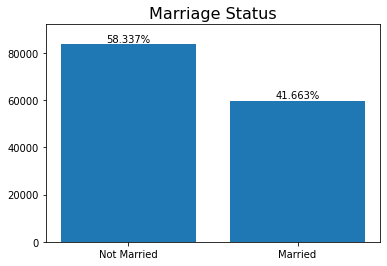

OrderedDict([(0, 136414), (1, 7045)])


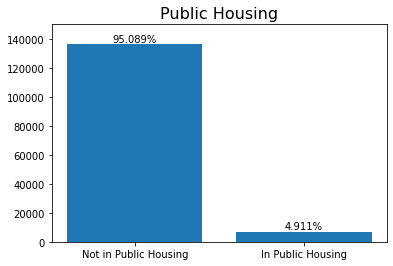

OrderedDict([(0, 68845), (1, 74614)])


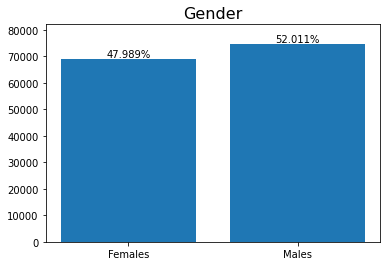

OrderedDict([(0, 42104), (1, 101355)])


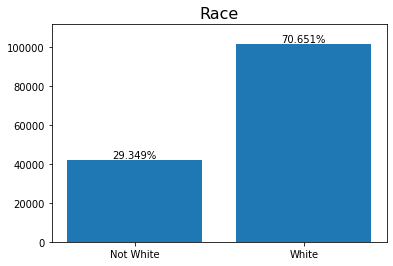

OrderedDict([(0, 48085), (1, 95374)])


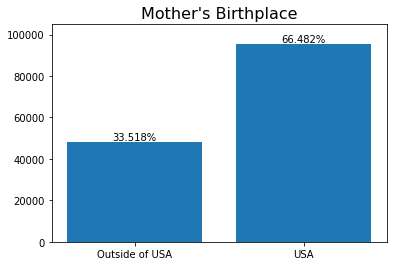

OrderedDict([(0, 57942), (1, 85517)])


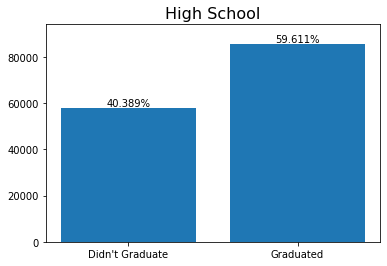

OrderedDict([(0, 108084), (1, 35375)])


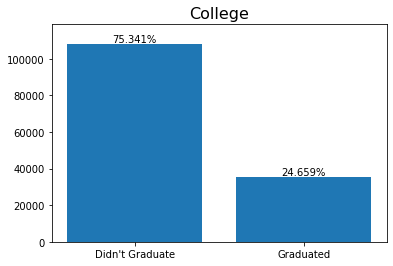

OrderedDict([(0, 13854), (1, 129605)])


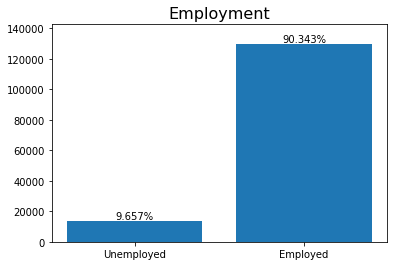

In [ ]:
import matplotlib.pyplot as plt
from collections import OrderedDict
'''
binary_var = ['marriage_status', 'PUBHOUS', 'SEX', 'RACE', 'MBPL', 'High School', 'College', 'Employment']
summary_binary = {}
for i in binary_var:
  # summary_binary[i] = df_income_main[i].value_counts().astype(int).to_dict()
  a = df_income_main[i].value_counts().astype(int).to_dict()
  print(a)
  x = list(a.keys())
  y = list(a.values())  
  plt.figure()
  bars = plt.bar(x,y)
  for rect in bars:
    height = rect.get_height() #'%d' % int(height)
    plt.text(rect.get_x() + rect.get_width()/2.0, height, f'{round(100*height/143459.0,3)}%', ha='center', va='bottom')

  plt.title(f"{i}")
  plt.show()
'''
binary_var = ['marriage_status', 'PUBHOUS', 'SEX', 'RACE', 'MBPL', 'High School', 'College', 'Employment']


def data_frequency(data, variable, title=None, xlabel=None):
  data_dict = data[variable].value_counts().astype(int).to_dict()
  data_dict = OrderedDict(sorted(data_dict.items()))
  print(data_dict)
  x = list(data_dict.keys())
  y = list(data_dict.values())
  plt.figure()
  bars = plt.bar(xlabel,y)
  plt.ylim(0,float(max(y))*1.1)
  for rect in bars:
    height = rect.get_height() #'%d' % int(height)
    plt.text(rect.get_x() + rect.get_width()/2.0, height, f'{round(100*height/143459.0,3)}%', ha='center', va='bottom')
  plt.title(title, fontsize=16)
  plt.savefig(variable+".png")
  plt.show()

data_frequency(df_income_main, variable="marriage_status",title="Marriage Status", xlabel=["Not Married", "Married"])
data_frequency(df_income_main, variable="PUBHOUS",title="Public Housing", xlabel=["Not in Public Housing", "In Public Housing"])
data_frequency(df_income_main, variable="SEX", title="Gender", xlabel=["Females", "Males"])
data_frequency(df_income_main, variable="RACE", title="Race", xlabel=["Not White", "White"])
data_frequency(df_income_main, variable="MBPL", title="Mother's Birthplace", xlabel=["Outside of USA", "USA"])
data_frequency(df_income_main, variable="High School", title="High School", xlabel=["Didn't Graduate", "Graduated"])
data_frequency(df_income_main, variable="College", title="College", xlabel=["Didn't Graduate", "Graduated"])
data_frequency(df_income_main, variable="Employment", title="Employment", xlabel=["Unemployed", "Employed"])

In [ ]:
df_income["PUBHOUS"].value_counts()

0    341087
1     17561
Name: PUBHOUS, dtype: int64

# LINEAR REGRESSION

In [ ]:
# Add constant term to dataset
df_income_main['const'] = 1

# Create lists of variables to be used in each regression
X1 = ['const', 'marriage_status']
X2 = ['const', 'marriage_status', 'PUBHOUS']
X3 = ['const', 'marriage_status', 'PUBHOUS', 'AGE']
X4 = ['const', 'marriage_status', 'PUBHOUS', 'AGE', 'SEX']
X5 = ['const', 'marriage_status', 'PUBHOUS', 'AGE', 'SEX', 'RACE']
X6 = ['const', 'marriage_status', 'PUBHOUS', 'AGE', 'SEX', 'RACE', 'MBPL']
X7 = ['const', 'marriage_status', 'PUBHOUS', 'AGE', 'SEX', 'RACE', 'MBPL', 'High School']
X8 = ['const', 'marriage_status', 'PUBHOUS', 'AGE', 'SEX', 'RACE', 'MBPL', 'High School', 'College']
X9 = ['const', 'marriage_status', 'PUBHOUS', 'AGE', 'SEX', 'RACE', 'MBPL', 'High School', 'College', 'Employment']


# Estimate an OLS regression for each set of variables
reg1 = sm.OLS(df_income_main['INCWAGE'], df_income_main[X1], missing='drop').fit()
reg2 = sm.OLS(df_income_main['INCWAGE'], df_income_main[X2], missing='drop').fit()
reg3 = sm.OLS(df_income_main['INCWAGE'], df_income_main[X3], missing='drop').fit()
reg4 = sm.OLS(df_income_main['INCWAGE'], df_income_main[X4], missing='drop').fit()
reg5 = sm.OLS(df_income_main['INCWAGE'], df_income_main[X5], missing='drop').fit()
reg6 = sm.OLS(df_income_main['INCWAGE'], df_income_main[X6], missing='drop').fit()
reg7 = sm.OLS(df_income_main['INCWAGE'], df_income_main[X7], missing='drop').fit()
reg8 = sm.OLS(df_income_main['INCWAGE'], df_income_main[X8], missing='drop').fit()
reg9 = sm.OLS(df_income_main['INCWAGE'], df_income_main[X9], missing='drop').fit()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:

info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=[reg1,reg2,reg3,reg4,reg5,reg6,reg7,reg8,reg9],
                            float_format='%0.2f',
                            stars = True,
                            model_names=['Model 1',
                                         'Model 2',
                                         'Model 3',
                                         'Model 4',
                                         'Model 5',
                                         'Model 6',
                                         'Model 7',
                                         'Model 8',
                                         'Model 9'],
                            info_dict=info_dict,
                            regressor_order=['const',
                                             'marriage_status',
                                             'PUBHOUS',
                                             'AGE',
                                             'SEX',
                                             'RACE',
                                             'MBPL',
                                             'High School',
                                             'College',
                                             'Employment'])

results_table.add_title('Table 1 -  Linear Regression')

if latex:
  print(results_table.as_latex())
else:
  print(results_table)

                                                   Table 1 -  Linear Regression
                   Model 1     Model 2      Model 3      Model 4      Model 5      Model 6      Model 7      Model 8     Model 9   
-----------------------------------------------------------------------------------------------------------------------------------
const            29173.51*** 30125.02***  17903.02***  13288.43***  13517.69***  10645.22***  16917.49***  -3473.65*** -15765.47***
                 (156.40)    (159.32)     (363.26)     (381.62)     (427.73)     (465.29)     (479.43)     (511.93)    (592.16)    
marriage_status  7384.54***  6996.53***   5063.50***   4324.03***   4337.22***   4956.10***   4776.44***   4581.05***  4226.48***  
                 (242.30)    (241.96)     (246.27)     (245.85)     (246.10)     (249.06)     (247.09)     (239.64)    (238.44)    
PUBHOUS                      -16084.15*** -16016.39*** -14849.59*** -14915.44*** -15006.23*** -14204.30*** -9728.75*** -8516.66*

# Male Regression

In [ ]:
df_male = df_income_main.loc[df_income_main["SEX"]==1]
df_male

,YEAR,SERIAL,MONTH,HWTFINL,CPSID,ASECFLAG,HFLAG,ASECWTH,STATEFIP,STATECENSUS,HHINCOME,PUBHOUS,FAMINC,QFAMINC,QPUBHOUS,HRHHID,HRHHID2,PERNUM,WTFINL,CPSIDP,ASECWT,AGE,SEX,RACE,MARST,QAGE,QMARST,QSEX,QRACE,NCHILD,YNGCH,FTYPE,FAMREL,MBPL,FBPL,QFBPL,QMBPL,EMPSTAT,OCC,IND,CLASSWKR,QCLASSWK,QEMPSTAT,QIND,QOCC,EDUC,EDUC99,QEDUC,FAMID,OCCLY,CLASSWLY,WKSWORK1,WKSWORK2,QCLASSWL,QOCCLY,QWKSWORK,FTOTVAL,INCTOT,INCWAGE,INCCAPG,QINCCAPG,ADJGINC,CAPGAIN,CAPLOSS,MIGSTA1,MIGSTA5,QMIGST1B,CSYRDIV,HOURWAGE,QHOURWAG,TAVG1,VOTERES,NILF,Employment,High School,College,marriage_status,Marriage_Rate,const
195838,2008,92715,3,nan,0,1.0,nan,1906.6,6,93,157759.0,0,830,nan,0.0,94961207041608,83002,1,nan,0,1906.6,51,1,1,4,0,0,0,nan,0,99,2,0,1,1,0,0,10,7330,7190,21,0.0,0.0,0,0,73,10,0,1.0,7330.0,22.0,48.0,5.0,0.0,0.0,0.0,68343.0,68343.0,50000.0,nan,nan,73515.0,9148.0,0.0,6.0,nan,0.0,9998.0,1000.0,0,nan,nan,0,1,1,0,0.0,0.5,1
3037693,2019,3152,3,nan,20180306562300,1.0,nan,363.8,50,13,103005.0,0,830,nan,1.0,99300389411005,8011,1,nan,20180306562301,363.8,35,1,1,6,0,0,0,nan,0,99,2,0,1,1,0,0,10,1410,3390,21,4.0,0.0,0,0,123,16,0,1.0,1360.0,22.0,52.0,6.0,1.0,0.0,0.0,103005.0,103005.0,96000.0,9999999.0,0.0,103005.0,nan,nan,99.0,nan,0.0,nan,1000.0,0,nan,nan,0,1,0,1,0.0,0.4,1
1874017,2017,30139,3,nan,20160205907800,1.0,nan,420.6,46,45,19200.0,1,100,nan,0.0,34046527404371,5011,2,nan,20160205907803,541.1,21,1,0,6,0,0,0,nan,0,99,1,3,1,1,0,0,10,4700,5090,21,0.0,0.0,0,0,73,10,0,1.0,4700.0,22.0,52.0,6.0,0.0,0.0,0.0,19200.0,19200.0,19200.0,nan,nan,19200.0,nan,nan,99.0,nan,0.0,nan,1000.0,0,nan,nan,0,1,1,0,0.0,0.3,1
794527,2011,82062,3,nan,20101204460300,1.0,nan,542.4,32,88,38100.0,0,740,nan,0.0,454306400200531,88001,2,nan,20101204460302,542.4,23,1,1,1,0,0,0,0.0,0,99,1,2,1,1,0,0,10,6230,770,21,0.0,0.0,0,0,81,11,0,1.0,6230.0,22.0,52.0,6.0,0.0,0.0,0.0,38100.0,28800.0,28800.0,nan,nan,0.0,nan,nan,99.0,nan,0.0,nan,14.0,0,nan,nan,0,1,1,0,1.0,0.4,1
300393,2009,44001,3,nan,0,1.0,nan,1337.2,24,52,111200.0,0,996,nan,0.0,489210923840722,83001,1,nan,0,1337.2,21,1,0,6,0,0,0,nan,0,99,1,1,1,1,0,0,10,5850,7270,21,0.0,0.0,0,0,81,11,0,1.0,5850.0,22.0,52.0,6.0,0.0,0.0,1.0,83200.0,59200.0,33200.0,nan,nan,57363.0,nan,nan,99.0,nan,0.0,nan,1000.0,0,nan,nan,0,1,1,0,0.0,0.4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197245,2008,93372,3,nan,0,1.0,nan,1274.4,6,93,57955.0,0,996,nan,0.0,933056743019300,83001,1,nan,0,1274.4,37,1,1,1,0,0,0,nan,3,9,1,1,0,0,0,0,10,5610,1080,21,0.0,0.0,0,0,30,5,0,1.0,5610.0,22.0,52.0,6.0,0.0,0.0,0.0,57955.0,32008.0,32000.0,nan,nan,40856.0,0.0,0.0,99.0,nan,0.0,9998.0,1000.0,0,nan,nan,0,1,0,0,1.0,0.5,1
2132876,2018,68709,3,nan,20161203909900,1.0,nan,194.3,30,81,111602.0,0,841,nan,0.0,451606006530915,6111,1,nan,20161203909901,194.3,56,1,1,1,0,0,0,nan,0,99,1,1,1,1,0,0,10,6660,9590,25,0.0,0.0,0,0,111,15,0,1.0,6660.0,25.0,52.0,6.0,0.0,0.0,0.0,111602.0,111501.0,55000.0,nan,nan,55202.0,nan,nan,99.0,nan,0.0,nan,25.0,0,nan,nan,0,1,0,1,1.0,0.4,1
1344620,2014,56012,3,nan,0,1.0,0.0,3129.5,4,86,58000.0,0,820,nan,0.0,80946097001209,92001,1,nan,0,3129.5,18,1,1,6,0,0,0,nan,1,4,2,0,1,1,0,0,10,7160,8770,21,0.0,0.0,0,0,73,10,0,1.0,7160.0,22.0,52.0,6.0,0.0,0.0,0.0,38000.0,38000.0,38000.0,nan,nan,38000.0,nan,nan,4.0,nan,0.0,nan,1000.0,0,nan,nan,0,1,1,0,0.0,0.4,1
1615375,2015,92336,3,nan,20140200568700,1.0,nan,1789.8,6,93,230337.0,0,843,nan,0.0,860016063001904,93001,2,nan,20140200568702,1789.8,45,1,1,1,0,0,0,nan,3,12,1,2,0,0,0,0,10,20,6390,21,0.0,0.0,0,0,81,11,0,1.0,20.0,22.0,52.0,6.0,0.0,0.0,0.0,230337.0,210433.0,200000.0,nan,nan,0.0,nan,nan,47.0,6.0,0.0,nan,1000.0,0,nan,nan,0,1,1,0,1.0,0.5,1


In [ ]:
X1 = ['const', 'marriage_status']
X2 = ['const', 'marriage_status', 'PUBHOUS']
X3 = ['const', 'marriage_status', 'PUBHOUS', 'AGE']
X4 = ['const', 'marriage_status', 'PUBHOUS', 'AGE', 'RACE']
X5 = ['const', 'marriage_status', 'PUBHOUS', 'AGE', 'RACE', 'MBPL']
X6 = ['const', 'marriage_status', 'PUBHOUS', 'AGE', 'RACE', 'MBPL', 'High School']
X7 = ['const', 'marriage_status', 'PUBHOUS', 'AGE', 'RACE', 'MBPL', 'High School', 'College']
X8 = ['const', 'marriage_status', 'PUBHOUS', 'AGE', 'RACE', 'MBPL', 'High School', 'College', 'Employment']


# Estimate an OLS regression for each set of variables
reg1 = sm.OLS(df_male['INCWAGE'], df_male[X1], missing='drop').fit()
reg2 = sm.OLS(df_male['INCWAGE'], df_male[X2], missing='drop').fit()
reg3 = sm.OLS(df_male['INCWAGE'], df_male[X3], missing='drop').fit()
reg4 = sm.OLS(df_male['INCWAGE'], df_male[X4], missing='drop').fit()
reg5 = sm.OLS(df_male['INCWAGE'], df_male[X5], missing='drop').fit()
reg6 = sm.OLS(df_male['INCWAGE'], df_male[X6], missing='drop').fit()
reg7 = sm.OLS(df_male['INCWAGE'], df_male[X7], missing='drop').fit()
reg8 = sm.OLS(df_male['INCWAGE'], df_male[X8], missing='drop').fit()


In [ ]:
info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=[reg1,reg2,reg3,reg4,reg5,reg6,reg7,reg8],
                            float_format='%0.2f',
                            stars = True,
                            model_names=['Model 1',
                                         'Model 2',
                                         'Model 3',
                                         'Model 4',
                                         'Model 5',
                                         'Model 6',
                                         'Model 7',
                                         'Model 8'],
                            info_dict=info_dict,
                            regressor_order=['const',  
                                             'marriage_status', 
                                             'PUBHOUS', 
                                             'AGE', 
                                             'RACE', 
                                             'MBPL',
                                             'High School', 
                                             'College',
                                             'Employment'])

results_table.add_title('Table 2 - Male Only Regression')

if latex:
  print(results_table.as_latex())
else:
  print(results_table)

                                            Table 2 - Male Only Regression
                   Model 1     Model 2      Model 3      Model 4      Model 5      Model 6      Model 7      Model 8   
-----------------------------------------------------------------------------------------------------------------------
const            32012.50*** 32769.30***  19656.09***  19051.28***  15809.87***  22174.97***  1884.24**    -11286.77***
                 (258.99)    (261.90)     (586.01)     (674.86)     (719.29)     (745.59)     (783.34)     (919.25)    
marriage_status  10750.80*** 10545.55***  7984.84***   7961.71***   8796.12***   8634.27***   8561.52***   7974.75***  
                 (383.93)    (383.28)     (395.21)     (395.41)     (400.22)     (397.85)     (386.17)     (384.91)    
PUBHOUS                      -18164.53*** -17905.33*** -17749.91*** -17796.56*** -17138.49*** -12642.94*** -11072.93***
                             (1017.50)    (1013.33)    (1016.96)    (1015.84)    (100

#Female Regression

In [ ]:
df_female = df_income_main.loc[df_income_main["SEX"]==0]
df_female

,YEAR,SERIAL,MONTH,HWTFINL,CPSID,ASECFLAG,HFLAG,ASECWTH,STATEFIP,STATECENSUS,HHINCOME,PUBHOUS,FAMINC,QFAMINC,QPUBHOUS,HRHHID,HRHHID2,PERNUM,WTFINL,CPSIDP,ASECWT,AGE,SEX,RACE,MARST,QAGE,QMARST,QSEX,QRACE,NCHILD,YNGCH,FTYPE,FAMREL,MBPL,FBPL,QFBPL,QMBPL,EMPSTAT,OCC,IND,CLASSWKR,QCLASSWK,QEMPSTAT,QIND,QOCC,EDUC,EDUC99,QEDUC,FAMID,OCCLY,CLASSWLY,WKSWORK1,WKSWORK2,QCLASSWL,QOCCLY,QWKSWORK,FTOTVAL,INCTOT,INCWAGE,INCCAPG,QINCCAPG,ADJGINC,CAPGAIN,CAPLOSS,MIGSTA1,MIGSTA5,QMIGST1B,CSYRDIV,HOURWAGE,QHOURWAG,TAVG1,VOTERES,NILF,Employment,High School,College,marriage_status,Marriage_Rate,const
1395025,2014,79505,3,nan,20131205894100,1.0,1.0,1139.5,46,45,123500.0,0,842,nan,0.0,264381031409369,93001,1,nan,20131205894101,1139.5,26,0,1,1,0,0,0,nan,0,99,1,1,1,1,0,0,10,5700,180,21,0.0,0.0,0,0,92,14,0,1.0,5700.0,22.0,52.0,6.0,0.0,0.0,0.0,123500.0,26250.0,25000.0,nan,nan,123500.0,nan,nan,99.0,nan,0.0,nan,13.0,0,nan,nan,0,1,1,0,1.0,0.3,1
1377567,2014,70837,3,nan,20140201067300,1.0,1.0,3059.7,9,16,121080.0,0,842,nan,0.0,490430023908574,93001,1,nan,20140201067301,3059.7,42,0,1,6,0,0,0,nan,0,99,2,0,0,0,0,0,10,60,8680,21,0.0,0.0,0,0,111,15,0,1.0,60.0,22.0,52.0,6.0,0.0,0.0,0.0,99080.0,99080.0,99000.0,nan,nan,99080.0,nan,nan,99.0,nan,0.0,nan,1000.0,0,nan,nan,0,1,0,1,0.0,0.4,1
1096770,2013,32955,3,nan,20130102519100,1.0,nan,549.2,19,42,41250.0,0,740,nan,0.0,760199719900998,91001,2,nan,20130102519102,549.2,35,0,1,1,0,0,0,0.0,3,4,1,2,0,1,0,0,10,5120,8660,21,0.0,0.0,0,0,81,11,0,1.0,5120.0,22.0,52.0,6.0,0.0,0.0,0.0,41250.0,20000.0,20000.0,nan,nan,0.0,nan,nan,99.0,nan,0.0,nan,1000.0,0,nan,nan,0,1,1,0,1.0,0.4,1
252918,2009,22174,3,nan,0,1.0,nan,1311.8,39,31,36570.0,0,600,nan,0.0,71643190973896,86001,1,nan,0,1311.8,35,0,0,1,0,0,0,nan,4,0,1,1,0,1,0,0,12,4110,8680,21,0.0,0.0,0,0,81,11,0,1.0,4110.0,22.0,52.0,6.0,0.0,0.0,0.0,36570.0,18000.0,7500.0,nan,nan,21580.0,nan,nan,99.0,nan,0.0,nan,1000.0,0,nan,nan,0,1,1,0,1.0,0.4,1
3060020,2019,15156,3,nan,20180305399100,1.0,nan,3290.8,42,23,27600.0,0,710,nan,0.0,37022937401861,8011,1,nan,20180305399101,3290.8,38,0,1,6,0,0,0,nan,0,99,2,0,1,1,0,0,10,20,6280,21,0.0,0.0,0,0,81,11,0,1.0,20.0,22.0,44.0,4.0,0.0,0.0,0.0,27600.0,27600.0,24000.0,9999999.0,0.0,27600.0,nan,nan,99.0,nan,0.0,nan,1000.0,0,nan,nan,0,1,1,0,0.0,0.4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220882,2013,92462,3,nan,20130300611200,1.0,nan,2149.9,6,93,44000.0,0,710,nan,0.0,4906350985166,90002,1,nan,20130300611201,2149.9,22,0,0,6,0,0,0,0.0,0,99,2,0,1,1,0,0,10,4110,8680,21,0.0,0.0,0,0,81,11,0,1.0,4110.0,22.0,52.0,6.0,0.0,0.0,0.0,44000.0,44000.0,44000.0,nan,nan,44000.0,nan,nan,13.0,nan,4.0,nan,1000.0,0,nan,nan,0,1,1,0,0.0,0.5,1
3141399,2019,59589,3,nan,20190100363100,1.0,nan,735.9,5,71,46416.0,0,210,nan,1.0,44005262003461,8012,1,nan,20190100363101,735.9,20,0,1,6,0,0,0,nan,0,99,1,1,1,1,0,0,10,3500,8090,21,0.0,0.0,0,0,81,11,0,1.0,3420.0,22.0,52.0,6.0,1.0,0.0,0.0,19416.0,9000.0,9000.0,9999999.0,0.0,9000.0,nan,nan,99.0,nan,0.0,nan,1000.0,0,nan,nan,0,1,1,0,0.0,0.4,1
1599117,2015,85476,3,nan,20140104104500,1.0,nan,714.9,32,88,72317.0,0,210,nan,0.0,230207963719373,93001,1,nan,20140104104501,714.9,39,0,1,4,0,0,0,nan,1,16,1,1,1,1,0,0,10,1220,9470,28,0.0,0.0,0,0,81,11,0,1.0,1220.0,27.0,52.0,6.0,0.0,0.0,0.0,72317.0,72306.0,70000.0,nan,nan,72306.0,nan,nan,99.0,0.0,0.0,nan,1000.0,0,nan,nan,0,1,1,0,0.0,0.4,1
3180646,2019,79982,3,nan,20190306268200,1.0,nan,744.5,49,87,177000.0,0,740,nan,1.0,273019796409671,9011,4,nan,20190306268203,889.5,27,0,1,6,0,0,0,nan,0,99,5,0,1,1,0,0,10,4040,8680,21,0.0,0.0,0,0,92,14,0,3.0,4040.0,22.0,52.0,6.0,1.0,0.0,0.0,46000.0,46000.0,46000.0,9999999.0,0.0,46000.0,nan,nan,99.0,nan,0.0,nan,1000.0,0,nan,nan,0,1,1,0,0.0,0.5,1


In [ ]:
X1 = ['const', 'marriage_status']
X2 = ['const', 'marriage_status', 'PUBHOUS']
X3 = ['const', 'marriage_status', 'PUBHOUS', 'AGE']
X4 = ['const', 'marriage_status', 'PUBHOUS', 'AGE', 'RACE']
X5 = ['const', 'marriage_status', 'PUBHOUS', 'AGE', 'RACE', 'MBPL']
X6 = ['const', 'marriage_status', 'PUBHOUS', 'AGE', 'RACE', 'MBPL', 'High School']
X7 = ['const', 'marriage_status', 'PUBHOUS', 'AGE', 'RACE', 'MBPL', 'High School', 'College']
X8 = ['const', 'marriage_status', 'PUBHOUS', 'AGE', 'RACE', 'MBPL', 'High School', 'College', 'Employment']


# Estimate an OLS regression for each set of variables
reg1 = sm.OLS(df_female['INCWAGE'], df_female[X1], missing='drop').fit()
reg2 = sm.OLS(df_female['INCWAGE'], df_female[X2], missing='drop').fit()
reg3 = sm.OLS(df_female['INCWAGE'], df_female[X3], missing='drop').fit()
reg4 = sm.OLS(df_female['INCWAGE'], df_female[X4], missing='drop').fit()
reg5 = sm.OLS(df_female['INCWAGE'], df_female[X5], missing='drop').fit()
reg6 = sm.OLS(df_female['INCWAGE'], df_female[X6], missing='drop').fit()
reg7 = sm.OLS(df_female['INCWAGE'], df_female[X7], missing='drop').fit()
reg8 = sm.OLS(df_female['INCWAGE'], df_female[X8], missing='drop').fit()


In [ ]:
info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=[reg1,reg2,reg3,reg4,reg5,reg6,reg7,reg8],
                            float_format='%0.2f',
                            stars = True,
                            model_names=['Model 1',
                                         'Model 2',
                                         'Model 3',
                                         'Model 4',
                                         'Model 5',
                                         'Model 6',
                                         'Model 7',
                                         'Model 8'],
                            info_dict=info_dict,
                            regressor_order=['const',  
                                             'marriage_status', 
                                             'PUBHOUS', 
                                             'AGE', 
                                             'RACE', 
                                             'MBPL',
                                             'High School', 
                                             'College',
                                             'Employment'])

results_table.add_title('Table 3 - Female Only Regression')

if latex:
  print(results_table.as_latex())
else:
  print(results_table)

                                          Table 3 - Female Only Regression
                   Model 1     Model 2      Model 3      Model 4      Model 5      Model 6      Model 7     Model 8  
---------------------------------------------------------------------------------------------------------------------
const            26491.00*** 27497.16***  16367.63***  17296.08***  15432.53***  21605.60***  2628.70***  -8221.18***
                 (170.90)    (175.32)     (407.27)     (459.83)     (511.53)     (525.26)     (572.80)    (659.84)   
marriage_status  1904.83***  1446.07***   112.87       184.05       556.38*      384.89       149.76      14.60      
                 (279.09)    (278.60)     (280.27)     (280.71)     (284.13)     (280.49)     (270.73)    (268.72)   
PUBHOUS                      -13293.22*** -13265.63*** -13541.47*** -13618.04*** -12714.40*** -8707.26*** -7739.22***
                             (556.16)     (552.51)     (556.07)     (555.87)     (549.09)     (532.

# INSTRUMENTAL VARIABLE

In [ ]:
#FIRST STAGE
controls =['const', 'PUBHOUS', 'AGE','SEX', 'RACE', 'MBPL', 'High School', 'College', 'Employment']
First_Stage = IV2SLS(df_income_main.marriage_status, df_income_main[controls + ['Marriage_Rate']], None, None).fit(cov_type='unadjusted')



if latex:
  print(First_Stage.summary.as_latex())
else:
  display(First_Stage.summary)

/usr/local/lib/python3.6/dist-packages/linearmodels/iv/data.py:25: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


<class 'linearmodels.compat.statsmodels.Summary'>
"""
                            OLS Estimation Summary                            
==============================================================================
Dep. Variable:        marriage_status   R-squared:                      0.0851
Estimator:                        OLS   Adj. R-squared:                 0.0851
No. Observations:              143459   F-statistic:                 1.335e+04
Date:                Sat, Dec 19 2020   P-value (F-stat)                0.0000
Time:                        19:20:34   Distribution:                  chi2(9)
Cov. Estimator:            unadjusted                                         
                                                                              
                               Parameter Estimates                               
=================================================================================
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
const            -0.1503     0.0119    -12.670     0.0000     -0.1735     -0.1270
PUBHOUS          -0.0776     0.0058    -13.286     0.0000     -0.0891     -0.0662
AGE               0.0078  9.813e-05     79.118     0.0000      0.0076      0.0080
SEX               0.0629     0.0025     25.055     0.0000      0.0580      0.0678
RACE              0.0526     0.0028     18.962     0.0000      0.0471      0.0580
MBPL             -0.1447     0.0028    -51.899     0.0000     -0.1502     -0.1393
High School      -0.0112     0.0037    -3.0550     0.0023     -0.0184     -0.0040
College           0.0098     0.0041     2.3742     0.0176      0.0017      0.0180
Employment        0.0589     0.0043     13.772     0.0000      0.0505      0.0673
Marriage_Rate     0.6303     0.0231     27.231     0.0000      0.5849      0.6756
=================================================================================
"""

In [ ]:
#REDUCED FORM
Reduced_Form = IV2SLS(df_income_main.INCWAGE, df_income_main[controls + ['Marriage_Rate']], None, None).fit(cov_type='unadjusted')

if latex:
  print(Reduced_Form.summary.as_latex())
else:
  display(Reduced_Form.summary)

/usr/local/lib/python3.6/dist-packages/linearmodels/iv/data.py:25: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


<class 'linearmodels.compat.statsmodels.Summary'>
"""
                            OLS Estimation Summary                            
==============================================================================
Dep. Variable:                INCWAGE   R-squared:                      0.1134
Estimator:                        OLS   Adj. R-squared:                 0.1134
No. Observations:              143459   F-statistic:                 1.836e+04
Date:                Sat, Dec 19 2020   P-value (F-stat)                0.0000
Time:                        19:20:34   Distribution:                  chi2(9)
Cov. Estimator:            unadjusted                                         
                                                                              
                               Parameter Estimates                               
=================================================================================
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
const         -1.852e+04     1075.0    -17.228     0.0000  -2.063e+04  -1.641e+04
PUBHOUS          -8797.3     529.69    -16.608     0.0000     -9835.4     -7759.1
AGE               347.75     8.8936     39.101     0.0000      330.32      365.18
SEX            1.069e+04     227.56     46.965     0.0000   1.024e+04   1.113e+04
RACE              282.97     251.22     1.1264     0.2600     -209.40      775.35
MBPL              1715.7     252.78     6.7873     0.0000      1220.3      2211.2
High School       9454.6     332.16     28.464     0.0000      8803.5   1.011e+04
College        3.371e+04     375.96     89.656     0.0000   3.297e+04   3.444e+04
Employment     1.598e+04     387.55     41.237     0.0000   1.522e+04   1.674e+04
Marriage_Rate     7617.4     2097.7     3.6313     0.0003      3506.0   1.173e+04
=================================================================================
"""

In [ ]:
#SECOND STAGE
Second_Stage = IV2SLS(df_income_main.INCWAGE, df_income_main[controls], df_income_main.marriage_status, df_income_main['Marriage_Rate']).fit(cov_type='robust')

if latex:
  print(Second_Stage.summary.as_latex())
else:
  display(Second_Stage.summary)

/usr/local/lib/python3.6/dist-packages/linearmodels/iv/data.py:25: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                INCWAGE   R-squared:                      0.1086
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1085
No. Observations:              143459   F-statistic:                 1.535e+04
Date:                Sat, Dec 19 2020   P-value (F-stat)                0.0000
Time:                        19:20:35   Distribution:                  chi2(9)
Cov. Estimator:                robust                                         
                                                                              
                                Parameter Estimates                                
===================================================================================
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
const            -1.67e+04     655.11    -25.497     0.0000  -1.799e+04  -1.542e+04
PUBHOUS            -7858.8     434.47    -18.088     0.0000     -8710.4     -7007.3
AGE                 253.92     29.126     8.7179     0.0000      196.83      311.01
SEX                 9927.1     312.41     31.776     0.0000      9314.8   1.054e+04
RACE               -352.24     303.78    -1.1595     0.2463     -947.64      243.16
MBPL                3465.2     610.62     5.6748     0.0000      2268.4      4662.0
High School         9589.9     244.79     39.176     0.0000      9110.1   1.007e+04
College          3.359e+04     384.08     87.450     0.0000   3.284e+04   3.434e+04
Employment       1.527e+04     336.25     45.411     0.0000   1.461e+04   1.593e+04
marriage_status  1.209e+04     3523.4     3.4303     0.0006      5180.5   1.899e+04
===================================================================================

Endogenous: marriage_status
Instruments: Marriage_Rate
Robust Covariance (Heteroskedastic)
Debiased: False
"""

#IV FOR MALES

In [ ]:
#FIRST STAGE
controls =['const', 'PUBHOUS', 'AGE', 'RACE', 'MBPL', 'High School', 'College', 'Employment']
First_Stage = IV2SLS(df_male.marriage_status, df_male[controls + ['Marriage_Rate']], None, None).fit(cov_type='unadjusted')

if latex:
  print(First_Stage.summary.as_latex())
else:
  display(First_Stage.summary)

/usr/local/lib/python3.6/dist-packages/linearmodels/iv/data.py:25: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


<class 'linearmodels.compat.statsmodels.Summary'>
"""
                            OLS Estimation Summary                            
==============================================================================
Dep. Variable:        marriage_status   R-squared:                      0.1014
Estimator:                        OLS   Adj. R-squared:                 0.1013
No. Observations:               74614   F-statistic:                    8418.5
Date:                Sat, Dec 19 2020   P-value (F-stat)                0.0000
Time:                        19:20:35   Distribution:                  chi2(8)
Cov. Estimator:            unadjusted                                         
                                                                              
                               Parameter Estimates                               
=================================================================================
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
const            -0.1946     0.0163    -11.902     0.0000     -0.2266     -0.1625
PUBHOUS          -0.0410     0.0093    -4.4100     0.0000     -0.0592     -0.0228
AGE               0.0099     0.0001     71.922     0.0000      0.0096      0.0102
RACE              0.0400     0.0039     10.145     0.0000      0.0323      0.0477
MBPL             -0.1398     0.0038    -36.725     0.0000     -0.1473     -0.1323
High School      -0.0174     0.0049    -3.5748     0.0004     -0.0269     -0.0079
College          -0.0027     0.0056    -0.4827     0.6293     -0.0137      0.0083
Employment        0.0896     0.0059     15.245     0.0000      0.0780      0.1011
Marriage_Rate     0.6605     0.0323     20.448     0.0000      0.5972      0.7239
=================================================================================
"""

In [ ]:
#REDUCED FORM
Reduced_Form = IV2SLS(df_male.INCWAGE, df_male[controls + ['Marriage_Rate']], None, None).fit(cov_type='unadjusted')

if latex:
  print(Reduced_Form.summary.as_latex())
else:
  display(Reduced_Form.summary)

/usr/local/lib/python3.6/dist-packages/linearmodels/iv/data.py:25: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


<class 'linearmodels.compat.statsmodels.Summary'>
"""
                            OLS Estimation Summary                            
==============================================================================
Dep. Variable:                INCWAGE   R-squared:                      0.0962
Estimator:                        OLS   Adj. R-squared:                 0.0962
No. Observations:               74614   F-statistic:                    7946.3
Date:                Sat, Dec 19 2020   P-value (F-stat)                0.0000
Time:                        19:20:36   Distribution:                  chi2(8)
Cov. Estimator:            unadjusted                                         
                                                                              
                               Parameter Estimates                               
=================================================================================
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
const         -1.618e+04     1728.1    -9.3655     0.0000  -1.957e+04   -1.28e+04
PUBHOUS       -1.132e+04     982.58    -11.525     0.0000  -1.325e+04     -9397.9
AGE               394.74     14.547     27.136     0.0000      366.22      423.25
RACE              2220.7     416.83     5.3277     0.0000      1403.8      3037.7
MBPL              2060.3     402.42     5.1197     0.0000      1271.5      2849.0
High School    1.033e+04     513.98     20.107     0.0000      9327.2   1.134e+04
College        3.772e+04     592.05     63.707     0.0000   3.656e+04   3.888e+04
Employment     1.747e+04     621.04     28.128     0.0000   1.625e+04   1.869e+04
Marriage_Rate  1.308e+04     3415.1     3.8311     0.0001      6390.0   1.978e+04
=================================================================================
"""

In [ ]:
#SECOND STAGE
Second_Stage = IV2SLS(df_male.INCWAGE, df_male[controls], df_male.marriage_status, df_male['Marriage_Rate']).fit(cov_type='robust')

if latex:
  print(Second_Stage.summary.as_latex())
else:
  display(Second_Stage.summary)

/usr/local/lib/python3.6/dist-packages/linearmodels/iv/data.py:25: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                INCWAGE   R-squared:                      0.0899
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0898
No. Observations:               74614   F-statistic:                    6893.6
Date:                Sat, Dec 19 2020   P-value (F-stat)                0.0000
Time:                        19:20:36   Distribution:                  chi2(8)
Cov. Estimator:                robust                                         
                                                                              
                                Parameter Estimates                                
===================================================================================
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
const           -1.233e+04     860.99    -14.322     0.0000  -1.402e+04  -1.064e+04
PUBHOUS         -1.051e+04     665.17    -15.803     0.0000  -1.182e+04     -9208.2
AGE                 198.72     56.255     3.5325     0.0004      88.464      308.98
RACE                1428.4     451.74     3.1621     0.0016      543.03      2313.8
MBPL                4829.1     909.48     5.3098     0.0000      3046.6      6611.7
High School      1.068e+04     393.41     27.144     0.0000      9907.7   1.145e+04
College          3.777e+04     628.12     60.135     0.0000   3.654e+04     3.9e+04
Employment        1.57e+04     650.49     24.128     0.0000   1.442e+04   1.697e+04
marriage_status  1.981e+04     5352.1     3.7009     0.0002      9317.3    3.03e+04
===================================================================================

Endogenous: marriage_status
Instruments: Marriage_Rate
Robust Covariance (Heteroskedastic)
Debiased: False
"""

#IV FOR FEMALES

In [ ]:
#FIRST STAGE
controls =['const', 'PUBHOUS', 'AGE', 'RACE', 'MBPL', 'High School', 'College', 'Employment']
First_Stage = IV2SLS(df_female.marriage_status, df_female[controls + ['Marriage_Rate']], None, None).fit(cov_type='unadjusted')

if latex:
  print(First_Stage.summary.as_latex())
else:
  display(First_Stage.summary)

/usr/local/lib/python3.6/dist-packages/linearmodels/iv/data.py:25: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


<class 'linearmodels.compat.statsmodels.Summary'>
"""
                            OLS Estimation Summary                            
==============================================================================
Dep. Variable:        marriage_status   R-squared:                      0.0618
Estimator:                        OLS   Adj. R-squared:                 0.0617
No. Observations:               68845   F-statistic:                    4538.6
Date:                Sat, Dec 19 2020   P-value (F-stat)                0.0000
Time:                        19:20:36   Distribution:                  chi2(8)
Cov. Estimator:            unadjusted                                         
                                                                              
                               Parameter Estimates                               
=================================================================================
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
const            -0.0366     0.0169    -2.1612     0.0307     -0.0698     -0.0034
PUBHOUS          -0.1007     0.0075    -13.448     0.0000     -0.1154     -0.0861
AGE               0.0056     0.0001     39.888     0.0000      0.0053      0.0058
RACE              0.0640     0.0039     16.481     0.0000      0.0564      0.0716
MBPL             -0.1499     0.0041    -36.665     0.0000     -0.1579     -0.1418
High School      -0.0033     0.0056    -0.5950     0.5518     -0.0142      0.0076
College           0.0200     0.0062     3.2208     0.0013      0.0078      0.0321
Employment        0.0255     0.0062     4.1044     0.0000      0.0133      0.0377
Marriage_Rate     0.5988     0.0330     18.129     0.0000      0.5341      0.6636
=================================================================================
"""

In [ ]:
#REDUCED FORM
Reduced_Form = IV2SLS(df_female.INCWAGE, df_female[controls + ['Marriage_Rate']], None, None).fit(cov_type='unadjusted')

if latex:
  print(Reduced_Form.summary.as_latex())
else:
  display(Reduced_Form.summary)

/usr/local/lib/python3.6/dist-packages/linearmodels/iv/data.py:25: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


<class 'linearmodels.compat.statsmodels.Summary'>
"""
                            OLS Estimation Summary                            
==============================================================================
Dep. Variable:                INCWAGE   R-squared:                      0.1268
Estimator:                        OLS   Adj. R-squared:                 0.1267
No. Observations:               68845   F-statistic:                    9997.1
Date:                Sat, Dec 19 2020   P-value (F-stat)                0.0000
Time:                        19:20:37   Distribution:                  chi2(8)
Cov. Estimator:            unadjusted                                         
                                                                              
                               Parameter Estimates                               
=================================================================================
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
const            -8981.1     1197.1    -7.5026     0.0000  -1.133e+04     -6634.9
PUBHOUS          -7723.9     529.41    -14.589     0.0000     -8761.5     -6686.2
AGE               292.80     9.8559     29.708     0.0000      273.48      312.12
RACE             -1475.6     274.39    -5.3777     0.0000     -2013.4     -937.80
MBPL              1196.9     288.84     4.1437     0.0000      630.74      1763.0
High School       8060.7     393.99     20.459     0.0000      7288.5      8832.9
College        2.923e+04     438.06     66.715     0.0000   2.837e+04   3.008e+04
Employment     1.423e+04     439.26     32.398     0.0000   1.337e+04   1.509e+04
Marriage_Rate     1780.4     2334.4     0.7627     0.4457     -2795.0      6355.7
=================================================================================
"""

In [ ]:
#SECOND STAGE
Second_Stage = IV2SLS(df_female.INCWAGE, df_female[controls], df_female.marriage_status, df_female['Marriage_Rate']).fit(cov_type='robust')

if latex:
  print(Second_Stage.summary.as_latex())
else:
  display(Second_Stage.summary)

/usr/local/lib/python3.6/dist-packages/linearmodels/iv/data.py:25: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                INCWAGE   R-squared:                      0.1253
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1252
No. Observations:               68845   F-statistic:                 1.043e+04
Date:                Sat, Dec 19 2020   P-value (F-stat)                0.0000
Time:                        19:20:37   Distribution:                  chi2(8)
Cov. Estimator:                robust                                         
                                                                              
                                Parameter Estimates                                
===================================================================================
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
const              -8872.2     1141.8    -7.7703     0.0000  -1.111e+04     -6634.3
PUBHOUS            -7424.3     572.37    -12.971     0.0000     -8546.2     -6302.5
AGE                 276.26     25.550     10.813     0.0000      226.18      326.34
RACE               -1665.8     390.55    -4.2654     0.0000     -2431.3     -900.39
MBPL                1642.4     768.53     2.1370     0.0326      136.10      3148.7
High School         8070.5     249.42     32.358     0.0000      7581.7      8559.4
College          2.917e+04     412.59     70.690     0.0000   2.836e+04   2.997e+04
Employment       1.416e+04     295.41     47.917     0.0000   1.358e+04   1.473e+04
marriage_status     2973.1     4367.6     0.6807     0.4960     -5587.1   1.153e+04
===================================================================================

Endogenous: marriage_status
Instruments: Marriage_Rate
Robust Covariance (Heteroskedastic)
Debiased: False
"""

#State Fixed Effects

In [ ]:
df_state_FE = df_income_main.copy()
df_state_FE = pd.get_dummies(df_state_FE, prefix=['STATEFIP'], columns=['STATEFIP'])
df_state_FE = df_state_FE.drop(["STATEFIP_6"], axis=1)
#df_state_FE.iloc[:, -50:] #Just to see we have 49 states and DC

In [ ]:
df_income_main["STATEFIP"].value_counts()

6     19706
48     9224
36     7978
12     6350
17     4106
11     4003
13     3320
15     3087
34     3065
39     3049
51     3025
42     2947
37     2925
32     2868
8      2829
53     2795
24     2709
25     2416
41     2327
9      2195
26     2164
27     2116
4      2102
55     2009
20     1934
44     1931
22     1896
19     1875
47     1870
2      1762
31     1748
38     1731
29     1730
33     1722
35     1693
40     1693
5      1679
10     1650
30     1647
16     1642
49     1638
46     1609
1      1576
21     1572
45     1567
18     1564
56     1481
28     1317
50     1290
23     1257
54     1070
Name: STATEFIP, dtype: int64

In [ ]:
# Create lists of variables to be used in each regression
states_list = ["STATEFIP_" + str(i) for i in test]
states_list.remove("STATEFIP_6") #Removes california from states list to preserve collinearity


X1 = ['const', 'marriage_status'] + states_list
X2 = ['const', 'marriage_status', 'PUBHOUS'] + states_list
X3 = ['const', 'marriage_status', 'PUBHOUS', 'AGE'] + states_list
X4 = ['const', 'marriage_status', 'PUBHOUS', 'AGE', 'SEX'] + states_list
X5 = ['const', 'marriage_status', 'PUBHOUS', 'AGE', 'SEX', 'RACE'] + states_list
X6 = ['const', 'marriage_status', 'PUBHOUS', 'AGE', 'SEX', 'RACE', 'MBPL'] + states_list
X7 = ['const', 'marriage_status', 'PUBHOUS', 'AGE', 'SEX', 'RACE', 'MBPL', 'High School'] + states_list
X8 = ['const', 'marriage_status', 'PUBHOUS', 'AGE', 'SEX', 'RACE', 'MBPL', 'High School', 'College'] +states_list
X9 = ['const', 'marriage_status', 'PUBHOUS', 'AGE', 'SEX', 'RACE', 'MBPL', 'High School', 'College', 'Employment'] +states_list

# Estimate an OLS regression for each set of variables
reg1 = sm.OLS(df_state_FE['INCWAGE'], df_state_FE[X1], missing='drop').fit()
reg2 = sm.OLS(df_state_FE['INCWAGE'], df_state_FE[X2], missing='drop').fit()
reg3 = sm.OLS(df_state_FE['INCWAGE'], df_state_FE[X3], missing='drop').fit()
reg4 = sm.OLS(df_state_FE['INCWAGE'], df_state_FE[X4], missing='drop').fit()
reg5 = sm.OLS(df_state_FE['INCWAGE'], df_state_FE[X5], missing='drop').fit()
reg6 = sm.OLS(df_state_FE['INCWAGE'], df_state_FE[X6], missing='drop').fit()
reg7 = sm.OLS(df_state_FE['INCWAGE'], df_state_FE[X7], missing='drop').fit()
reg8 = sm.OLS(df_state_FE['INCWAGE'], df_state_FE[X8], missing='drop').fit()
reg9 = sm.OLS(df_state_FE['INCWAGE'], df_state_FE[X9], missing='drop').fit()

In [ ]:
info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}
latex = True
results_table = summary_col(results=[reg1,reg2,reg3,reg4,reg5,reg6,reg7,reg8,reg9],
                            float_format='%0.2f',
                            stars = True,
                            model_names=['Model 1',
                                         'Model 2',
                                         'Model 3',
                                         'Model 4',
                                         'Model 5',
                                         'Model 6',
                                         'Model 7',
                                         'Model 8',
                                         'Model 9'],
                            info_dict=info_dict,
                            regressor_order=X8)

results_table.add_title('Table 5 - State Fix Effects')

if latex:
  print(results_table.as_latex())
else:
  print(results_table)

\begin{table}
\caption{Table 5 - State Fix Effects}
\begin{center}
\begin{tabular}{lccccccccc}
\hline
                 &   Model 1   &   Model 2    &   Model 3    &   Model 4    &   Model 5    &   Model 6    &   Model 7    &   Model 8   &   Model 9     \\
\midrule
const            & 30392.01*** & 31050.25***  & 19087.34***  & 14242.43***  & 13705.36***  & 11051.15***  & 16900.95***  & -2406.17*** & -14477.03***  \\
                 & (341.27)    & (340.95)     & (474.48)     & (488.93)     & (532.34)     & (544.58)     & (556.10)     & (579.58)    & (647.64)      \\
marriage\_status & 7478.18***  & 7114.23***   & 5262.88***   & 4542.37***   & 4514.79***   & 5366.83***   & 5125.78***   & 4778.86***  & 4441.95***    \\
                 & (242.77)    & (242.34)     & (246.64)     & (246.13)     & (246.37)     & (248.89)     & (247.20)     & (240.23)    & (238.99)      \\
PUBHOUS          &             & -16387.85*** & -16311.66*** & -15158.55*** & -15019.41*** & -15037.36*** & -14288.29**

#Regression with fixed effect for male



In [ ]:
#CREATE FE DATASET FOR MALE ONLY
df_state_FE_male =  df_state_FE.copy()
df_state_FE_male = df_state_FE_male.drop(df_state_FE_male[df_state_FE_male['SEX'] == 0].index)
df_state_FE_male

,YEAR,SERIAL,MONTH,HWTFINL,CPSID,ASECFLAG,HFLAG,ASECWTH,STATECENSUS,HHINCOME,PUBHOUS,FAMINC,QFAMINC,QPUBHOUS,HRHHID,HRHHID2,PERNUM,WTFINL,CPSIDP,ASECWT,AGE,SEX,RACE,MARST,QAGE,QMARST,QSEX,QRACE,NCHILD,YNGCH,FTYPE,FAMREL,MBPL,FBPL,QFBPL,QMBPL,EMPSTAT,OCC,IND,CLASSWKR,...,STATEFIP_15,STATEFIP_16,STATEFIP_17,STATEFIP_18,STATEFIP_19,STATEFIP_20,STATEFIP_21,STATEFIP_22,STATEFIP_23,STATEFIP_24,STATEFIP_25,STATEFIP_26,STATEFIP_27,STATEFIP_28,STATEFIP_29,STATEFIP_30,STATEFIP_31,STATEFIP_32,STATEFIP_33,STATEFIP_34,STATEFIP_35,STATEFIP_36,STATEFIP_37,STATEFIP_38,STATEFIP_39,STATEFIP_40,STATEFIP_41,STATEFIP_42,STATEFIP_44,STATEFIP_45,STATEFIP_46,STATEFIP_47,STATEFIP_48,STATEFIP_49,STATEFIP_50,STATEFIP_51,STATEFIP_53,STATEFIP_54,STATEFIP_55,STATEFIP_56
195838,2008,92715,3,NaN,0,1.0,NaN,1906.64,93,157759.0,0,830,NaN,0.0,94961207041608,83002,1,NaN,0,1906.64,51,1,1,4,0,0,0,NaN,0,99,2,0,1,1,0,0,10,7330,7190,21,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3037693,2019,3152,3,NaN,20180306562300,1.0,NaN,363.79,13,103005.0,0,830,NaN,1.0,99300389411005,8011,1,NaN,20180306562301,363.79,35,1,1,6,0,0,0,NaN,0,99,2,0,1,1,0,0,10,1410,3390,21,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1874017,2017,30139,3,NaN,20160205907800,1.0,NaN,420.55,45,19200.0,1,100,NaN,0.0,34046527404371,5011,2,NaN,20160205907803,541.06,21,1,0,6,0,0,0,NaN,0,99,1,3,1,1,0,0,10,4700,5090,21,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
794527,2011,82062,3,NaN,20101204460300,1.0,NaN,542.38,88,38100.0,0,740,NaN,0.0,454306400200531,88001,2,NaN,20101204460302,542.38,23,1,1,1,0,0,0,0.0,0,99,1,2,1,1,0,0,10,6230,770,21,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
300393,2009,44001,3,NaN,0,1.0,NaN,1337.18,52,111200.0,0,996,NaN,0.0,489210923840722,83001,1,NaN,0,1337.18,21,1,0,6,0,0,0,NaN,0,99,1,1,1,1,0,0,10,5850,7270,21,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197245,2008,93372,3,NaN,0,1.0,NaN,1274.36,93,57955.0,0,996,NaN,0.0,933056743019300,83001,1,NaN,0,1274.36,37,1,1,1,0,0,0,NaN,3,9,1,1,0,0,0,0,10,5610,1080,21,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2132876,2018,68709,3,NaN,20161203909900,1.0,NaN,194.28,81,111602.0,0,841,NaN,0.0,451606006530915,6111,1,NaN,20161203909901,194.28,56,1,1,1,0,0,0,NaN,0,99,1,1,1,1,0,0,10,6660,9590,25,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1344620,2014,56012,3,NaN,0,1.0,0.0,3129.53,86,58000.0,0,820,NaN,0.0,80946097001209,92001,1,NaN,0,3129.53,18,1,1,6,0,0,0,NaN,1,4,2,0,1,1,0,0,10,7160,8770,21,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1615375,2015,92336,3,NaN,20140200568700,1.0,NaN,1789.76,93,230337.0,0,843,NaN,0.0,860016063001904,93001,2,NaN,20140200568702,1789.76,45,1,1,1,0,0,0,NaN,3,12,1,2,0,0,0,0,10,20,6390,21,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Create lists of variables to be used in each regression
states_list = ["STATEFIP_" + str(i) for i in test]
states_list.remove("STATEFIP_6") #Removes california from states list to preserve collinearity


X1 = ['const', 'marriage_status'] + states_list
X2 = ['const', 'marriage_status', 'PUBHOUS'] + states_list
X3 = ['const', 'marriage_status', 'PUBHOUS', 'AGE'] + states_list
X4 = ['const', 'marriage_status', 'PUBHOUS', 'AGE', 'RACE'] + states_list
X5 = ['const', 'marriage_status', 'PUBHOUS', 'AGE', 'RACE', 'MBPL'] + states_list
X6 = ['const', 'marriage_status', 'PUBHOUS', 'AGE', 'RACE', 'MBPL', 'High School'] + states_list
X7 = ['const', 'marriage_status', 'PUBHOUS', 'AGE', 'RACE', 'MBPL', 'High School', 'College'] +states_list
X8 = ['const', 'marriage_status', 'PUBHOUS', 'AGE', 'RACE', 'MBPL', 'High School', 'College', 'Employment'] +states_list

# Estimate an OLS regression for each set of variables
reg1 = sm.OLS(df_state_FE_male['INCWAGE'], df_state_FE_male[X1], missing='drop').fit()
reg2 = sm.OLS(df_state_FE_male['INCWAGE'], df_state_FE_male[X2], missing='drop').fit()
reg3 = sm.OLS(df_state_FE_male['INCWAGE'], df_state_FE_male[X3], missing='drop').fit()
reg4 = sm.OLS(df_state_FE_male['INCWAGE'], df_state_FE_male[X4], missing='drop').fit()
reg5 = sm.OLS(df_state_FE_male['INCWAGE'], df_state_FE_male[X5], missing='drop').fit()
reg6 = sm.OLS(df_state_FE_male['INCWAGE'], df_state_FE_male[X6], missing='drop').fit()
reg7 = sm.OLS(df_state_FE_male['INCWAGE'], df_state_FE_male[X7], missing='drop').fit()
reg8 = sm.OLS(df_state_FE_male['INCWAGE'], df_state_FE_male[X8], missing='drop').fit()

In [ ]:
info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=[reg1,reg2,reg3,reg4,reg5,reg6,reg7,reg8],
                            float_format='%0.2f',
                            stars = True,
                            model_names=['Model 1',
                                         'Model 2',
                                         'Model 3',
                                         'Model 4',
                                         'Model 5',
                                         'Model 6',
                                         'Model 7',
                                         'Model 8'],
                            info_dict=info_dict,
                            regressor_order=X8)

results_table.add_title('Table 6 - State Fix Effects for male population')

if latex:
  print(results_table.as_latex())
else:
  print(results_table)

\begin{table}
\caption{Table 6 - State Fix Effects for male population}
\begin{center}
\begin{tabular}{lcccccccc}
\hline
                 &   Model 1   &   Model 2    &   Model 3    &   Model 4    &   Model 5    &   Model 6    &   Model 7    &   Model 8     \\
\midrule
const            & 32589.03*** & 33153.04***  & 20292.01***  & 18893.64***  & 16399.54***  & 22372.34***  & 2912.08***   & -10035.40***  \\
                 & (537.66)    & (537.30)     & (754.78)     & (834.86)     & (846.75)     & (868.19)     & (894.64)     & (1010.39)     \\
marriage\_status & 10898.61*** & 10714.14***  & 8237.93***   & 8187.33***   & 9220.45***   & 8999.94***   & 8705.05***   & 8145.04***    \\
                 & (385.20)    & (384.45)     & (396.42)     & (396.60)     & (400.72)     & (398.66)     & (387.64)     & (386.30)      \\
PUBHOUS          &             & -18832.27*** & -18554.68*** & -18228.30*** & -18130.77*** & -17516.98*** & -12876.99*** & -11294.50***  \\
                 &            

#Regression with fixed effect for female

In [ ]:
#CREATE FE DATASET FOR MALE ONLY
df_state_FE_female =  df_state_FE.copy()
df_state_FE_female = df_state_FE_female.drop(df_state_FE_female[df_state_FE_female['SEX'] == 1].index)
df_state_FE_female

,YEAR,SERIAL,MONTH,HWTFINL,CPSID,ASECFLAG,HFLAG,ASECWTH,STATECENSUS,HHINCOME,PUBHOUS,FAMINC,QFAMINC,QPUBHOUS,HRHHID,HRHHID2,PERNUM,WTFINL,CPSIDP,ASECWT,AGE,SEX,RACE,MARST,QAGE,QMARST,QSEX,QRACE,NCHILD,YNGCH,FTYPE,FAMREL,MBPL,FBPL,QFBPL,QMBPL,EMPSTAT,OCC,IND,CLASSWKR,...,STATEFIP_15,STATEFIP_16,STATEFIP_17,STATEFIP_18,STATEFIP_19,STATEFIP_20,STATEFIP_21,STATEFIP_22,STATEFIP_23,STATEFIP_24,STATEFIP_25,STATEFIP_26,STATEFIP_27,STATEFIP_28,STATEFIP_29,STATEFIP_30,STATEFIP_31,STATEFIP_32,STATEFIP_33,STATEFIP_34,STATEFIP_35,STATEFIP_36,STATEFIP_37,STATEFIP_38,STATEFIP_39,STATEFIP_40,STATEFIP_41,STATEFIP_42,STATEFIP_44,STATEFIP_45,STATEFIP_46,STATEFIP_47,STATEFIP_48,STATEFIP_49,STATEFIP_50,STATEFIP_51,STATEFIP_53,STATEFIP_54,STATEFIP_55,STATEFIP_56
1395025,2014,79505,3,NaN,20131205894100,1.0,1.0,1139.54,45,123500.0,0,842,NaN,0.0,264381031409369,93001,1,NaN,20131205894101,1139.54,26,0,1,1,0,0,0,NaN,0,99,1,1,1,1,0,0,10,5700,180,21,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1377567,2014,70837,3,NaN,20140201067300,1.0,1.0,3059.67,16,121080.0,0,842,NaN,0.0,490430023908574,93001,1,NaN,20140201067301,3059.67,42,0,1,6,0,0,0,NaN,0,99,2,0,0,0,0,0,10,60,8680,21,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1096770,2013,32955,3,NaN,20130102519100,1.0,NaN,549.18,42,41250.0,0,740,NaN,0.0,760199719900998,91001,2,NaN,20130102519102,549.18,35,0,1,1,0,0,0,0.0,3,4,1,2,0,1,0,0,10,5120,8660,21,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
252918,2009,22174,3,NaN,0,1.0,NaN,1311.75,31,36570.0,0,600,NaN,0.0,71643190973896,86001,1,NaN,0,1311.75,35,0,0,1,0,0,0,NaN,4,0,1,1,0,1,0,0,12,4110,8680,21,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3060020,2019,15156,3,NaN,20180305399100,1.0,NaN,3290.78,23,27600.0,0,710,NaN,0.0,37022937401861,8011,1,NaN,20180305399101,3290.78,38,0,1,6,0,0,0,NaN,0,99,2,0,1,1,0,0,10,20,6280,21,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220882,2013,92462,3,NaN,20130300611200,1.0,NaN,2149.86,93,44000.0,0,710,NaN,0.0,4906350985166,90002,1,NaN,20130300611201,2149.86,22,0,0,6,0,0,0,0.0,0,99,2,0,1,1,0,0,10,4110,8680,21,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3141399,2019,59589,3,NaN,20190100363100,1.0,NaN,735.87,71,46416.0,0,210,NaN,1.0,44005262003461,8012,1,NaN,20190100363101,735.87,20,0,1,6,0,0,0,NaN,0,99,1,1,1,1,0,0,10,3500,8090,21,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1599117,2015,85476,3,NaN,20140104104500,1.0,NaN,714.87,88,72317.0,0,210,NaN,0.0,230207963719373,93001,1,NaN,20140104104501,714.87,39,0,1,4,0,0,0,NaN,1,16,1,1,1,1,0,0,10,1220,9470,28,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3180646,2019,79982,3,NaN,20190306268200,1.0,NaN,744.55,87,177000.0,0,740,NaN,1.0,273019796409671,9011,4,NaN,20190306268203,889.55,27,0,1,6,0,0,0,NaN,0,99,5,0,1,1,0,0,10,4040,8680,21,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
# Create lists of variables to be used in each regression
states_list = ["STATEFIP_" + str(i) for i in test]
states_list.remove("STATEFIP_6") #Removes california from states list to preserve collinearity


X1 = ['const', 'marriage_status'] + states_list
X2 = ['const', 'marriage_status', 'PUBHOUS'] + states_list
X3 = ['const', 'marriage_status', 'PUBHOUS', 'AGE'] + states_list
X4 = ['const', 'marriage_status', 'PUBHOUS', 'AGE', 'RACE'] + states_list
X5 = ['const', 'marriage_status', 'PUBHOUS', 'AGE', 'RACE', 'MBPL'] + states_list
X6 = ['const', 'marriage_status', 'PUBHOUS', 'AGE', 'RACE', 'MBPL', 'High School'] + states_list
X7 = ['const', 'marriage_status', 'PUBHOUS', 'AGE', 'RACE', 'MBPL', 'High School', 'College'] +states_list
X8 = ['const', 'marriage_status', 'PUBHOUS', 'AGE', 'RACE', 'MBPL', 'High School', 'College', 'Employment'] +states_list

# Estimate an OLS regression for each set of variables
reg1 = sm.OLS(df_state_FE_female['INCWAGE'], df_state_FE_female[X1], missing='drop').fit()
reg2 = sm.OLS(df_state_FE_female['INCWAGE'], df_state_FE_female[X2], missing='drop').fit()
reg3 = sm.OLS(df_state_FE_female['INCWAGE'], df_state_FE_female[X3], missing='drop').fit()
reg4 = sm.OLS(df_state_FE_female['INCWAGE'], df_state_FE_female[X4], missing='drop').fit()
reg5 = sm.OLS(df_state_FE_female['INCWAGE'], df_state_FE_female[X5], missing='drop').fit()
reg6 = sm.OLS(df_state_FE_female['INCWAGE'], df_state_FE_female[X6], missing='drop').fit()
reg7 = sm.OLS(df_state_FE_female['INCWAGE'], df_state_FE_female[X7], missing='drop').fit()
reg8 = sm.OLS(df_state_FE_female['INCWAGE'], df_state_FE_female[X8], missing='drop').fit()

In [ ]:
info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=[reg1,reg2,reg3,reg4,reg5,reg6,reg7,reg8],
                            float_format='%0.2f',
                            stars = True,
                            model_names=['Model 1',
                                         'Model 2',
                                         'Model 3',
                                         'Model 4',
                                         'Model 5',
                                         'Model 6',
                                         'Model 7',
                                         'Model 8'],
                            info_dict=info_dict,
                            regressor_order=X8)

results_table.add_title('Table 7 - State Fix Effects for female population')

if latex:
  print(results_table.as_latex())
else:
  print(results_table)

\begin{table}
\caption{Table 7 - State Fix Effects for female population}
\begin{center}
\begin{tabular}{lcccccccc}
\hline
                 &   Model 1   &   Model 2    &   Model 3    &   Model 4    &   Model 5    &   Model 6    &   Model 7   &   Model 8    \\
\midrule
const            & 27979.12*** & 28637.96***  & 17797.34***  & 17959.48***  & 15741.79***  & 21449.87***  & 3739.54***  & -6904.35***  \\
                 & (392.84)    & (392.15)     & (539.75)     & (589.23)     & (606.55)     & (617.06)     & (650.33)    & (722.76)     \\
marriage\_status & 2007.39***  & 1576.90***   & 320.85       & 331.23       & 975.54***    & 738.70***    & 410.49      & 285.95       \\
                 & (278.72)    & (278.12)     & (279.80)     & (280.21)     & (283.03)     & (279.96)     & (270.88)    & (268.82)     \\
PUBHOUS          &             & -13375.43*** & -13346.07*** & -13389.13*** & -13452.11*** & -12615.83*** & -8676.06*** & -7668.21***  \\
                 &             & (555.04